<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# A ver si salimos de pobres - LSTM _edition_<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-14</small></i></div>
                                                  

***

## Introducción

El anterior intento de predecir la bolsa no salió como esperábamos. Vamo a volver a intentarlo, esta vez con unas flamantes redes LSTM, y usando únicamente el valor de bolsa anterior.

## Objetivos

Crearemos un modelo de regresión de un valor de la bosla en base al valor anterior. Al finalizar habremos aprendido a:

- Predecir la tendencia de una serie temporal usando LSTM.
- Pensárselo dos veces antes de invertir en bolsa en base a las recomendaciones que hagan los modelos que nosotros hayamos programado.

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Carga y preparación de datos

Volveremos a cargar los datos del histórico de Google tal y como hicimos en el ejercicio número 03.esentar las notas que nos hará fácil más tarde convertir las notas generadas en una nueva pista de audio.

In [3]:
df = pd.read_csv('Datasets/GOOG-20211004.csv', parse_dates=['Date'], index_col='Date')
df = df.replace('[\$]', '', regex=True).astype('float32')
df.sort_index(inplace=True)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-03-27,558.460022,13052.0,568.000000,568.000000,552.919983
2014-03-28,559.989990,41003.0,561.200012,566.429993,558.669983
2014-03-31,556.969971,10772.0,566.890015,567.000000,556.929993
2014-04-01,567.159973,7932.0,558.710022,568.450012,558.710022
2014-04-02,567.000000,146697.0,599.989990,604.830017,562.190002


Vamos a obviar el reto de valores y a usar únicamente la evolución temporal del valor de cierre de la acción. Sin embargo, en lugar de usar el valor absoluto, lo que usaremos será la variación del valor con respecto al día anterior. No vamos a hacer ninguna transformación más allá de normalizar y poco más, así que podemos convertirlo a un array de numpy tranquilamente.

In [4]:
dataset = df[['Close/Last']].diff(axis=0).values[1:]
dataset

array([[  1.5299683],
       [ -3.0200195],
       [ 10.190002 ],
       ...,
       [-33.26001  ],
       [-25.109863 ],
       [ 63.93994  ]], dtype=float32)

Ahora crearemos un `MinMaxScaler` para hacer la normalización y desnormalización de nuestros datos. Aprovechamos y los dejamos ya normalizados.

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.49262467],
       [0.47625545],
       [0.52378035],
       ...,
       [0.36746287],
       [0.3967842 ],
       [0.7171532 ]], dtype=float32)

Ya tenemos nuestro conjunto de datos casi listo para trabajar sobre él. Lo siguiente será especificar la longitud de la secuencia, que es lo mismo que el número de timesteps o el número de observaciones previas a considerar para hacer una predicción.

Usaremos un tamaño de 20, lo que quiere decir que para predecir el valor de un día usará los 20 anteriores (aproximadamente un mes). Crearemos por tanto los conjuntos `X_train` e `Y_train`, dos arrays de NumPy que contendrán las secuencias y el siguiente valor de dicha secuencia respectivamente.

In [6]:
SEQUENCE_LEN = 10

x_train = []
y_train = []
for i in range(len(dataset) - SEQUENCE_LEN - 9):
    x_train.append(dataset[i:i + SEQUENCE_LEN, 0])
    y_train.append(dataset[i + SEQUENCE_LEN + 9, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

for i in range(10):
    print(f'... {x_train[i][-3:]} -> {y_train[i]}')
print(f'x_train shape: {x_train.shape}, Y_train shape: {y_train.shape}')

... [0.54738086 0.52036256 0.40369114] -> 0.4548136591911316
... [0.52036256 0.40369114 0.4498847 ] -> 0.4906102120876312
... [0.40369114 0.4498847  0.494028  ] -> 0.5250754356384277
... [0.4498847 0.494028  0.5012231] -> 0.48337870836257935
... [0.494028   0.5012231  0.55943286] -> 0.5039933323860168
... [0.5012231  0.55943286 0.41358465] -> 0.47481653094291687
... [0.55943286 0.41358465 0.4602101 ] -> 0.4866887032985687
... [0.41358465 0.4602101  0.50938976] -> 0.44153836369514465
... [0.4602101  0.50938976 0.458807  ] -> 0.4684845507144928
... [0.50938976 0.458807   0.4807165 ] -> 0.4908619523048401
x_train shape: (1874, 10), Y_train shape: (1874,)


Recordemos que los datos de entrada de una red recurrente tienen ue tener una dimensión específica, así que ahora los vamos a transformar para adaptarlos a ese requisito.

In [7]:
x_train = np.reshape(x_train, (*x_train.shape[:2], 1))

print(f'X_train shape: {x_train.shape}')

X_train shape: (1874, 10, 1)


Por último, ya que tenemos los datos preparados, vamos a extraer los últimos valores (por ejemplo 100) para que hagan las veces de conjunto de test.

In [8]:
TEST_SIZE = 250

x_train, x_test = x_train[:-TEST_SIZE], x_train[-TEST_SIZE:]
y_train, y_test = y_train[:-TEST_SIZE], y_train[-TEST_SIZE:]

print(f'X_train shape: {x_train.shape}, Y_train shape: {y_train.shape}')
print(f'X_test shape: {x_test.shape}, Y_test shape: {y_test.shape}')

X_train shape: (1624, 10, 1), Y_train shape: (1624,)
X_test shape: (250, 10, 1), Y_test shape: (250,)


## Implementando y entrenando nuestro modelo

Pasamos a construir nuestra red neuronal recurrente. Crearemos una estructura apilada de 3 nodos LSTM de 40 nodos cada uno, con una capa de Dropout tras cada capa. Luego, usaremos como optimizador Adam y como medida de pérdida el error cuadrático medio.

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               1

Ahora, entrenaremos el modelo durante... digamos 100 epochs, con los datos de entrenamiento que hemos preparado.

In [10]:
history = model.fit(x_train, y_train, epochs=10, verbose=0)

Veamos la evolución de nuestro entrenamiento

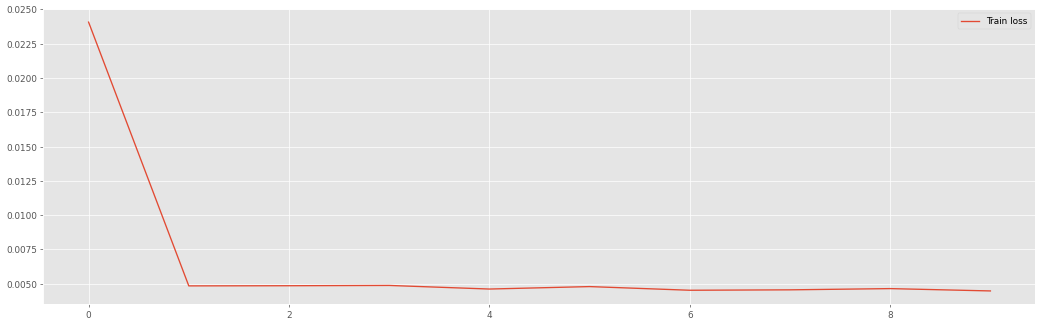

In [11]:
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

## Prediciendo los valores

Después de todo lo hecho, este es el paso sencillo. Tenemos que pasar nuestros dates de test para ver cómo se comporta nuestro modelo con valores que nunca ha visto. Los compararemos con los valores de verdad para ver qué tal lo hace

8/8 [==============================] - 2s 8ms/step


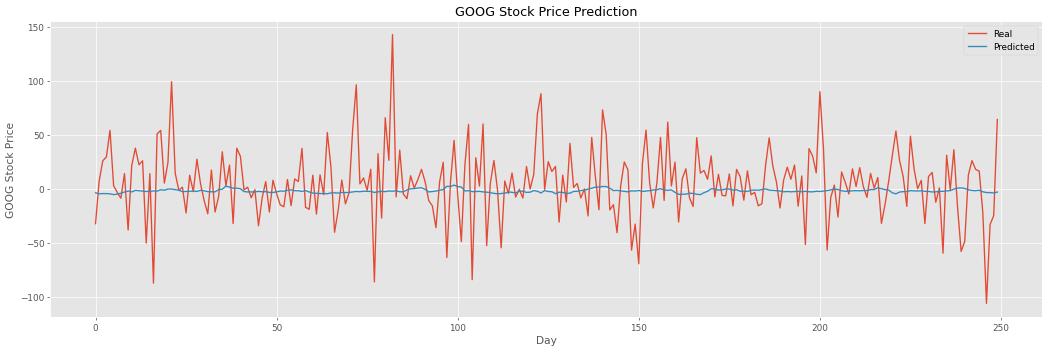

In [12]:
predicted = model.predict(x_test)
predicted = scaler.inverse_transform(predicted)
real = scaler.inverse_transform(y_test.reshape((-1, 1)))

plt.plot(real, label = 'Real')
plt.plot(predicted, label = 'Predicted')
plt.title('GOOG Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('GOOG Stock Price')
plt.legend()
plt.show()

Al menos no es un comportamiento como el anterior. Pero sigue siendo inútil. Por lo visto no nos vamos a hacer ricos. Al menos no así.

## Conclusiones

En este _notebook_ hemos aprendido que es muy fácil cambiar entre tipos de unidades recurrentes. La API de Keras nos permite reemplazar una y otra prácticamente sin esfuerzo.

También hemos visto que no todos los problemas de series temporales son resolubles, al menos no con los datos de los que diponemos a la primera. Desde luego que el valor en bolsa de unas acciones es una serie temporal, pero existen muchas variables relacionadas con los valroes, muchas de ellas emocionales de los propios propietarios de las acciones, por lo que es muy difícil identificarlas, obtenerlas y cuantificarlas. Aún así, si lo intentáis y os sale muy bien, no os olvidéis de nosotros.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>